In [1]:
%load_ext autoreload
%autoreload 2

# Generate embeddings

In [2]:
!pip install scanpy

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import scanpy

adata = scanpy.read_h5ad("/teamspace/studios/this_studio/embedders/data/blood_cell_scrna/adata.h5ad")
# adata = scanpy.read_h5ad("../data/blood_cell_scrna/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 94655 × 967
    obs: 'cell_type'
    var: 'gene_ids'

In [7]:
# Upgrade to sklearn 1.4 so we can use RMSE
!pip install --upgrade scikit-learn==1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 103.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import embedders
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


The relevant quote from the Tabaghi paper:

<blockquote>
To embed these datasets into different product space forms, we adapted and modified the
mixed-curvature VAEs algorithm of (Skopek et al., 2020). The original implementation of
this algorithm does not allow the users to choose the number of layers and hidden dimensions
of the network. So we introduce customized changes to make the approach suitable for use
with datasets at different scales. For the Lymphoma dataset, we use two MLP layers with
hidden dimension 200 and train the network for 500 epochs. For the blood cell landmark
dataset, we use three MLP layers with hidden dimension 400 and train the network for 200
epochs. Other experimental setups are the same as the ones stated in (Skopek et al., 2020).
</blockquote>

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(967, 400)
        self.fc2 = torch.nn.Linear(400, 400)
        self.fc3 = torch.nn.Linear(400, 400)
        self.fc4_z_mean = torch.nn.Linear(400, pm.dim)
        self.fc4_z_logvar = torch.nn.Linear(400, pm.dim)

    def forward(self, x):
        # Hidden layers
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))

        # Reparameterization
        z_mean_tangent = self.fc4_z_mean(h3)
        z_logvar = self.fc4_z_logvar(h3)
        z_mean = pm.manifold.expmap(x=pm.mu0, u=z_mean_tangent @ pm.projection_matrix)

        return z_mean, z_logvar


class Decoder(torch.nn.Module):
    def __init__(self, pm):
        super().__init__()
        self.pm = pm
        self.fc1 = torch.nn.Linear(pm.ambient_dim, 400)
        self.fc2 = torch.nn.Linear(400, 400)
        self.fc3 = torch.nn.Linear(400, 400)
        self.fc4 = torch.nn.Linear(400, 967)

    def forward(self, z):
        # Hidden layers
        h1 = torch.relu(self.fc1(z))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))

        # Output layer
        x = torch.sigmoid(self.fc4(h3))

        return x

In [10]:
# Process X
X = adata.X.todense()
X /= X.sum(axis=1)
X = torch.tensor(X).float()

In [18]:
from tqdm.notebook import tqdm

SIGNATURE = [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)]
BATCH_SIZE = 4_096
# N_EPOCHS = 200
N_EPOCHS = 20
# LR = 1e-5
# BETA = 0.01 # Lower penalty on KL-divergence
BETA = 1.0
N_SAMPLES = 64
# CLIP_GRAD = False

# Skopek hyperparamters (aka standard Adam hyperparameters)
LR = 1e-3
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8
CURVATURE_LR = 1e-4

# Manifold stuff
pm = embedders.manifolds.ProductManifold(SIGNATURE)
vae = embedders.vae.ProductSpaceVAE(
    pm=pm, encoder=Encoder(pm), decoder=Decoder(pm), beta=BETA, n_samples=N_SAMPLES, device=device
)

# Training stuff
opt = torch.optim.Adam([
    {vae.parameters(), lr=LR, betas=(BETA1, BETA2), eps=EPS},
    {pm.parameters(), lr=0, betas=(BETA1, BETA2), eps=EPS}
])

# Visualization stuff
my_tqdm = tqdm(total=N_EPOCHS * len(X))

# Device stuff
vae = vae.to(device)
X = X.to(device)
pm = pm.to(device)


# Gradient checking stuff
def grads_ok(vae):
    out = True
    for name, param in vae.named_parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")
                out = False
            if torch.isinf(param.grad).any():
                print(f"Inf gradient in {name}")
                out = False
    return out


losses = []
for epoch in range(N_EPOCHS):
    if epoch == 10:
        opt.param_groups[1]["lr"] = CURVATURE_LR
    for i in range(0, len(X), BATCH_SIZE):
        x_batch = X[i : i + BATCH_SIZE]

        elbo, ll, kl = vae.elbo(x_batch)
        loss = -elbo
        losses.append(loss.item())

        # Early stopping
        if len(losses) > 100 and loss.item() > 1.1 * min(losses[-50:]):


        opt.zero_grad()
        loss.backward()

        # Gradient clipping
        if CLIP_GRAD:
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        if torch.isnan(loss):
            print(f"Loss is NaN at iteration {i}")
        elif torch.isinf(loss):
            print(f"Loss is inf at iteration {i}")
        elif grads_ok(vae):
            opt.step()

        my_tqdm.update(BATCH_SIZE)
        my_tqdm.set_description(f"Epoch {epoch}, loss: {loss.item():.1f}, ll: {ll.item():.1f}, kl: {kl.item():.1f}")

  0%|          | 0/18931000 [00:00<?, ?it/s]

Loss is NaN at iteration 53248


In [19]:
# Generate and save embeddings
import numpy as np

embeddings = []
for i in range(0, len(X), BATCH_SIZE):
    x_batch = X[i : i + BATCH_SIZE]
    z_mean, _ = vae.encoder(x_batch)
    embeddings.append(z_mean.detach().cpu().numpy())

embeddings = np.concatenate(embeddings)
np.save("/teamspace/studios/this_studio/embedders/data/blood_cell_scrna/embeddings_s2_e2_h2_3.npy", embeddings)

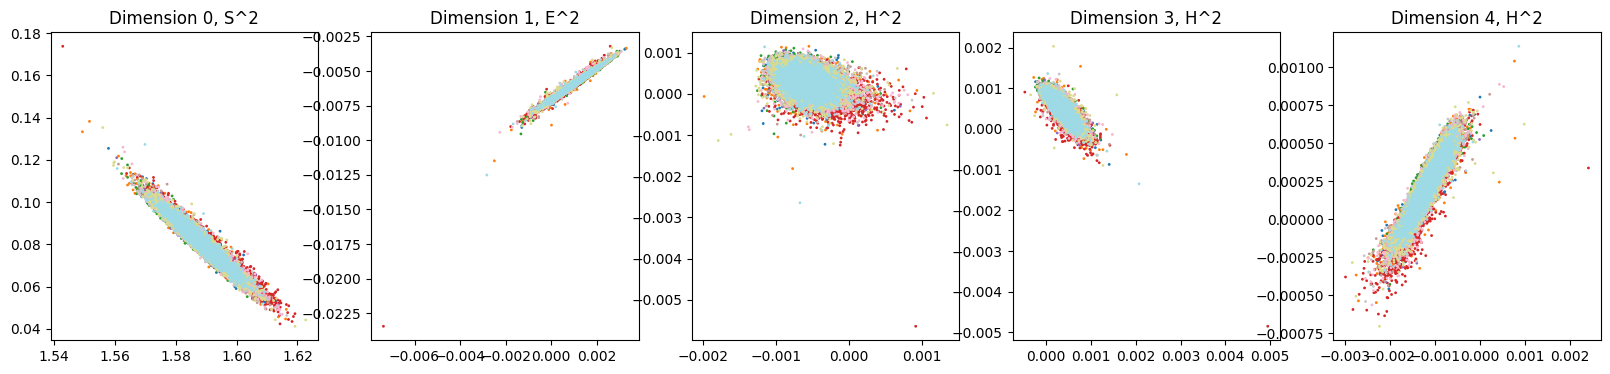

In [20]:
# Let's visualize the embeddings

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axs):
    M = pm.P[i]
    to_plot = torch.Tensor(embeddings[:, pm.man2dim[i]])
    if M.type == "S":
        to_plot = embedders.visualization.S2_to_polar(to_plot)
    elif M.type == "H":
        to_plot = embedders.visualization.hyperboloid_to_poincare(to_plot)
    to_plot = to_plot.numpy()
    ax.set_title(f"Dimension {i}, {M.type}^{M.dim}")
    ax.scatter(to_plot[:, 0], to_plot[:, 1], s=1, c=[int(x) for x in adata.obs["cell_type"]], cmap="tab20")

# Evaluate classification accuracy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import anndata

import embedders

# from hyperdt.product_space_DT import ProductSpaceDT
# from hyperdt.forest import ProductSpaceRF

# from embedders.tree import TorchProductSpaceDT as ProductSpaceDT
# from embedders.tree import TorchProductSpaceRF as ProductSpaceRF
from embedders.tree_new import ProductSpaceDT, ProductSpaceRF

# from hyperdt.torch.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [5]:
# Device

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [6]:
# Load data

X = torch.tensor(np.load("../data/blood_cell_scrna/embeddings_s2_e2_h2_3.npy"), requires_grad=False)
idx = np.random.choice(X.shape[0], 1_000, replace=False)
# X = X[idx]  # Take it easy

y = torch.tensor(
    [int(x) for x in anndata.read_h5ad("../data/blood_cell_scrna/adata.h5ad").obs["cell_type"]],
    requires_grad=False,
)
# y = y[idx]  # Take it easy

X = X.to(device)
y = y.to(device)

X.shape, y.shape

(torch.Size([94655, 14]), torch.Size([94655]))

In [7]:
SIGNATURE = [(1, 2), (0, 2), (-1, 2), (-1, 2), (-1, 2)]
pm = embedders.manifolds.ProductManifold(SIGNATURE, device=device)

# Downsample
# DOWNSAMPLE = 100  # About 2 mins, somehow
# DOWNSAMPLE = 100  # About 2 mins
# DOWNSAMPLE = 2_000  # About 4 mins
# DOWNSAMPLE = 10_000 # 4 mins on GPU
DOWNSAMPLE = None
MAX_DEPTH = 5
BATCH_SIZE = 1

# idx = np.random.choice(len(X), DOWNSAMPLE, replace=False)
idx = torch.randperm(len(X))[:DOWNSAMPLE]
X_sample = X[idx]
y_sample = y[idx]

kf = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

f1s_dt, f1s_pdt, f1s_rf, f1s_prf = [], [], [], []
accs_dt, accs_pdt, accs_rf, accs_prf = [], [], [], []

for train_index, test_index in kf.split(X_sample):
    test_index, train_index = train_index, test_index  # Hack to do 20% train, 80% test
    X_train, X_test = X_sample[train_index], X_sample[test_index]
    y_train, y_test = y_sample[train_index], y_sample[test_index]

    # X_train_np, X_test_np = X_train.detach().cpu().numpy(), X_test.detach().cpu().numpy()
    # y_train_np, y_test_np = y_train.detach().cpu().numpy(), y_test.detach().cpu().numpy()

    X_train, X_test, y_train, y_test = X_train.to("cpu"), X_test.to("cpu"), y_train.to("cpu"), y_test.to("cpu")

    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt.fit(X_train, y_train)
    f1s_dt.append(f1_score(y_test, dt.predict(X_test), average="micro"))
    accs_dt.append(accuracy_score(y_test, dt.predict(X_test)))
    print(".", end="")

    rf = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=12)
    rf.fit(X_train, y_train)
    f1s_rf.append(f1_score(y_test, rf.predict(X_test), average="micro"))
    accs_rf.append(accuracy_score(y_test, rf.predict(X_test)))
    print(".", end="")

    y_test_np = y_test
    X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

    pdt = ProductSpaceDT(max_depth=MAX_DEPTH, pm=pm, batch_size=BATCH_SIZE)
    pdt.fit(X_train, y_train)
    pdt_pred = pdt.predict(X_test).detach().cpu().numpy()
    f1s_pdt.append(f1_score(y_test_np, pdt_pred, average="micro"))
    accs_pdt.append(accuracy_score(y_test_np, pdt_pred))
    print(".", end="")

    prf = ProductSpaceRF(max_depth=MAX_DEPTH, n_estimators=12, pm=pm, batch_size=BATCH_SIZE)
    for tree in prf.trees:
        tree.pm = tree.pm.to(device)
    prf.fit(X_train, y_train)
    prf_pred = prf.predict(X_test).detach().cpu().numpy()
    f1s_prf.append(f1_score(y_test_np, prf_pred, average="micro"))
    accs_prf.append(accuracy_score(y_test_np, prf_pred))

    print(".", end="")
    print()

print()
print(f"Decision Tree: {np.mean(f1s_dt):.3f}")
print(f"Random Forest: {np.mean(f1s_rf):.3f}")
print(f"Product Space Decision Tree: {np.mean(f1s_pdt):.3f}")
print(f"Product Space Random Forest: {np.mean(f1s_prf):.3f}")

print()
print(f"Decision Tree: {np.mean(accs_dt):.3f}")
print(f"Random Forest: {np.mean(accs_rf):.3f}")
print(f"Product Space Decision Tree: {np.mean(accs_pdt):.3f}")
print(f"Product Space Random Forest: {np.mean(accs_prf):.3f}")

..

Calculating information gains:   0%|          | 0/189310 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/75990 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/21100 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/10690 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/5790 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/4900 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/10410 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6960 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/3450 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/54890 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/34570 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6100 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/28470 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/20320 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/13600 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/6720 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/113320 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/76110 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/18220 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/16030 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/2190 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/57890 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/16470 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/41420 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/37210 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/12960 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/1080 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/11880 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/24250 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/5800 [00:00<?, ?it/s]

Calculating information gains:   0%|          | 0/18450 [00:00<?, ?it/s]